<a href="https://colab.research.google.com/github/Derrick36Sun/2024-BCI-final-project/blob/master/Filtered.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data loading

In [ ]:
!pip install autoreject
!pip install mne
!pip install asrpy

import mne
import pandas as pd
import numpy as np
import os
from zipfile import ZipFile
from autoreject import AutoReject
from mne.preprocessing import ICA
!pip install mne_icalabel
import mne_icalabel
import asrpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 45.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.6/21.6 MB 54.3 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%%time
FILE_PATH = '/content/drive/Shareddrives/BCI/grasp-and-lift-eeg-detection.zip'

with ZipFile(os.path.join(FILE_PATH), 'r') as z:
  z.extractall()

path ='/content/train.zip'

with ZipFile(os.path.join(path), 'r') as z:
  z.extractall()


CPU times: user 27.8 s, sys: 8.51 s, total: 36.3 s
Wall time: 1min 22s


In [ ]:
N = 1 #Set number of people here 1~12

dir = os.listdir("/content/train/")
df = pd.DataFrame()
data_dir = []
event_dir = []

for i in dir:
  if "data" in i: data_dir.append(i)
  if "event" in i :event_dir.append(i)
data_dir = sorted(data_dir)
event_dir = sorted(event_dir)
print(data_dir)
print(event_dir)

#Order: 10 11 12 1 2 3 4 5 6 7 8 9

df_data = [] # data store in here
df_event = [] # event data store in here

series = 0

for i in range(N):
  person_data = pd.DataFrame()
  person_event = pd.DataFrame()
  for j in range(8): #8 Trials
    t_data = pd.read_csv('/content/train/'+ str(data_dir[(i+1)*(j+1)-1]))
    t_event = pd.read_csv('/content/train/'+ str(event_dir[(i+1)*(j+1)-1]))
    person_data = pd.concat([person_data, t_data], axis = 0)
    person_event = pd.concat([person_event, t_event], axis = 0)

  df_data.append(person_data)
  df_event.append(person_event)



list_EEG_data = []
for i in range(N):
  df_data[i] = df_data[i].iloc[:,1:]
  data = df_data[i].values.T  # Transpose the data to have channels x samples
  channel_names = df_data[i].columns.tolist()
  Fs = 500
  info = mne.create_info(ch_names=channel_names, sfreq=Fs, ch_types='eeg')
  raw = mne.io.RawArray(data, info)
  montage = mne.channels.make_standard_montage('standard_1020')
  raw.set_montage(montage)
  list_EEG_data.append(raw)



['subj10_series1_data.csv', 'subj10_series2_data.csv', 'subj10_series3_data.csv', 'subj10_series4_data.csv', 'subj10_series5_data.csv', 'subj10_series6_data.csv', 'subj10_series7_data.csv', 'subj10_series8_data.csv', 'subj11_series1_data.csv', 'subj11_series2_data.csv', 'subj11_series3_data.csv', 'subj11_series4_data.csv', 'subj11_series5_data.csv', 'subj11_series6_data.csv', 'subj11_series7_data.csv', 'subj11_series8_data.csv', 'subj12_series1_data.csv', 'subj12_series2_data.csv', 'subj12_series3_data.csv', 'subj12_series4_data.csv', 'subj12_series5_data.csv', 'subj12_series6_data.csv', 'subj12_series7_data.csv', 'subj12_series8_data.csv', 'subj1_series1_data.csv', 'subj1_series2_data.csv', 'subj1_series3_data.csv', 'subj1_series4_data.csv', 'subj1_series5_data.csv', 'subj1_series6_data.csv', 'subj1_series7_data.csv', 'subj1_series8_data.csv', 'subj2_series1_data.csv', 'subj2_series2_data.csv', 'subj2_series3_data.csv', 'subj2_series4_data.csv', 'subj2_series5_data.csv', 'subj2_series

#Data preprocessing


## 1. Artifact removal


##2. ICA

### Count function

In [ ]:
def count_labels_numbers(labels):
  # print(labels["labels"])
  Numbers_source = np.zeros(7)
  for i in labels["labels"]:
    if i == 'brain':
      Numbers_source[0]+=1
    elif i =="muscle artifact":
      Numbers_source[1]+=1
    elif i == "eye blink":
      Numbers_source[2]+=1
    elif i == "heart beat":
      Numbers_source[3]+=1
    elif i == "line":
      Numbers_source[4]+= 1
    elif i == "channel noise":
      Numbers_source[5]+=1
    elif i=="other":
      Numbers_source[6]+=1
  print(len(labels["labels"]))
  print(Numbers_source)


### Raw ICA

In [ ]:
# ICA

def Raw_ica(raw):
  ica = mne.preprocessing.ICA(n_components=32, random_state=97, max_iter=800)
  ica.fit(raw)

  raw_labels = mne_icalabel.label_components(raw, ica, 'iclabel')
  count_labels_numbers(raw_labels)
  print(raw_labels)
  count_labels_numbers(raw_labels)
  ica.plot_components()
  return [raw_labels, ica]

### ICA with filter

In [ ]:
#Filtered ICA
def Filtered_ica(raw):
  ica = mne.preprocessing.ICA(n_components=32, random_state=97, max_iter=800)
  raw_filter=raw.filter(l_freq=0, h_freq=50.0)
  ica.fit(raw_filter)

  # Apply ICLabel to classify the components

  filter_labels = mne_icalabel.label_components(raw_filter, ica, 'iclabel')
  print(filter_labels)
  count_labels_numbers(filter_labels)
  ica.plot_components()
  return [filter_labels, ica]

### ICA with ASR

In [ ]:
def ASR_ica(raw):
  asr = asrpy.ASR(sfreq=raw.info["sfreq"], cutoff=20)
  asr.fit(raw)
  raw_asr = asr.transform(raw)

  ica = mne.preprocessing.ICA(n_components=32, random_state=97, max_iter=800)
  ica.fit(raw_asr)
  asr_labels = mne_icalabel.label_components(raw_asr, ica, 'iclabel')
  print(asr_labels)
  count_labels_numbers(asr_labels)

  ica.plot_components()
  return [asr_labels, ica]

### Apply ICA

In [ ]:
# Raw_ica(raw)# run raw data ICA
raw=list_EEG_data[0].filter(l_freq=0, h_freq=50.0)


Filtering raw data in 1 contiguous segment
Setting up low-pass filter at 50 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal lowpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Upper passband edge: 50.00 Hz
- Upper transition bandwidth: 12.50 Hz (-6 dB cutoff frequency: 56.25 Hz)
- Filter length: 133 samples (0.266 s)



[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    1.8s


Using matplotlib as 2D backend.


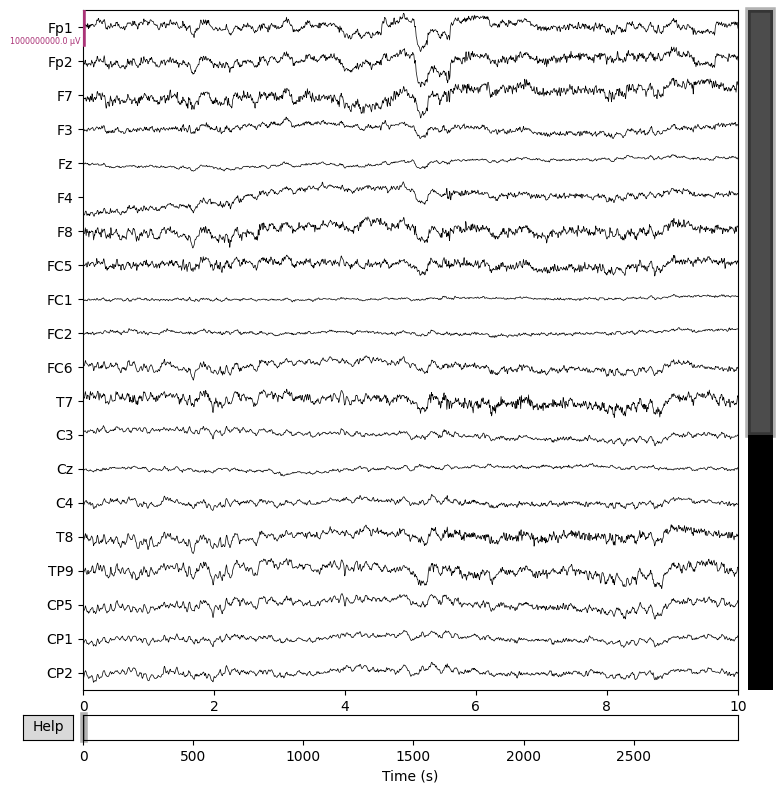

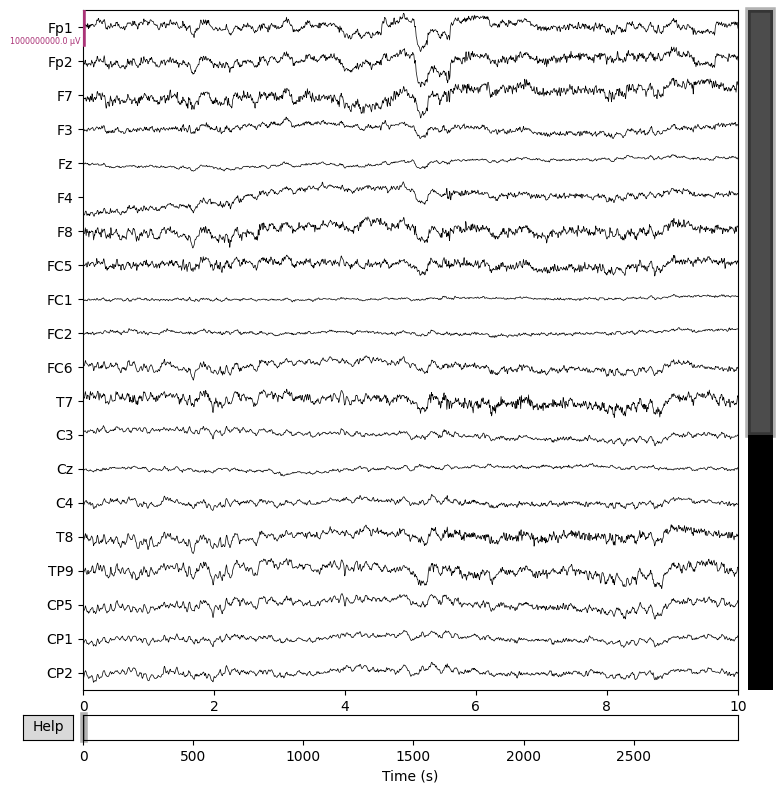

In [ ]:
raw.plot(scalings = {'eeg': 500})

### Adjust IClabels

## 3. Epochs Generation



In [ ]:
def Event(df):
  t = df.HandStart*1+ df.FirstDigitTouch*10+ df.BothStartLoadPhase*100+ df.LiftOff*(1000)+ df.Replace*(10000)+ df.BothReleased*(100000)
  if t !=1 and t !=10 and t !=100 and t !=1000 and t !=10000 and t !=100000     :
    t = 0
  return t



Epoch = []
for event in df_event:
  event["Epochs"] = event.apply(Event, axis=1)
  event =event.values.T  # Transpose the data to have channels x samples

  Epochs = event[7, 0:]
  i = 0
  start = Epochs[0]
  while True:

    if start == Epochs[i+1]: Epochs[i+1] = 0
    else: start = Epochs[i+1]
    i = i+1
    if i == len(Epochs)-1: break
  df_epochs = pd.DataFrame(Epochs).T

  event_timings = []
  events_id =[]
  for i in range(len(Epochs)):
    if Epochs[i] != 0:
      event_timings.append(i)
      events_id.append(Epochs[i])


  # 刪除同一個Epoch有2個以上事件
  print(event_timings)
  print(events_id)
  t = 0

  corrected_timing = []
  corrected_id = []

  # if event_timings[1]>event_timings[0]+0.5/(1/500)
  for i in range(1, len(event_timings)-1):

    if event_timings[i+1]>event_timings[i]+0.5/(1/500) and event_timings[i-1]<event_timings[i]-0.2/(1/500):
      corrected_timing.append(event_timings[i])
      corrected_id.append(events_id[i])
  print(t)
  print(len(event_timings))

  print(corrected_timing)
  print(corrected_id)

  # Pick EEG channels only
  raw.pick_types(meg=False, eeg=True, eog=True)


  event_dict = dict(condition_A=int(1), condition_C=int(100), condition_D = int(1000), condition_E = int(10000), condition_F =int(100000) )
  events = np.column_stack(
      (
          np.array(corrected_timing, dtype=int),
          np.zeros(len(corrected_timing), dtype=int),
          np.array(corrected_id, dtype=int)
      )
  )

  # 抓事件前0.2s~0.5s
  epochs_corrected = mne.Epochs(raw, events, tmin=-0.1, tmax=0.4, event_id=event_dict, preload=True)
  epochs_corrected.plot(
      picks = "eeg",
      events=events,
      scalings = {'eeg': 500},
      n_epochs = 6,
      n_channels = 1
  )


  Epoch.append(epochs_corrected)


# Feature Extraction

In [ ]:
from mne.decoding import CSP
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline


In [ ]:
from sklearn.svm import SVC
# Get the data and labels
X = Epoch[0].get_data()
y = Epoch[0].events[:, -1]

# Initialize the CSP object
csp = CSP(n_components=4, reg=None, log=True, cov_est='concat')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with CSP and LDA
clf = make_pipeline(csp,SVC(kernel='linear') ) #classifier

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification accuracy: {accuracy * 100:.2f}%')

# Visualize CSP patterns
csp.fit(X, y)
csp.plot_patterns(epochs_corrected.info, ch_type='eeg', units='Patterns (AU)', size=1.5)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

# Get the data and labels
X = Epoch[0].get_data()
y = Epoch[0].events[:, -1]

# Initialize the CSP object
csp = CSP(n_components=4, reg=None, log=True, cov_est='concat')

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline with CSP and LDA
clf = make_pipeline(csp,KNeighborsClassifier(n_neighbors=5)) #classifier

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Classification accuracy: {accuracy * 100:.2f}%')

# Visualize CSP patterns
csp.fit(X, y)
csp.plot_patterns(epochs_corrected.info, ch_type='eeg', units='Patterns (AU)', size=1.5)